<a href="https://colab.research.google.com/github/mskmei/MIDTERM-PROJECT-CV-2022Spring/blob/main/CIFAR100/notebook/CIFAR100_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-100 with ResNet and Data Augmentation

Author: [https://github.com/ForeverHaibara](https://github.com/ForeverHaibara)

In this experiment we demonstrate how to train a ResNet on CIFAR-100 with data augmentation.

CIFAR-100: [http://www.cs.toronto.edu/~kriz/cifar.html](http://www.cs.toronto.edu/~kriz/cifar.html)

## Load the Dataset

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt 
from tqdm import tqdm 

In [2]:
from torchvision.datasets import CIFAR100
data = CIFAR100(root = '../data/', train = True, download = True)
data_train = {'data': np.array([np.array(data[i][0]) for i in range(50000)]),
        'fine_labels': np.array([data[i][1] for i in range(50000)], dtype='uint8')}
del data 

data = CIFAR100(root = '../data/', train = False, download = True)
data_test = {'data': np.array([np.array(data[i][0]) for i in range(10000)]),
        'fine_labels': np.array([data[i][1] for i in range(10000)], dtype='uint8')}
del data

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# all classes of CIFAR-100
data_meta = 'apple aquarium_fish baby bear beaver bed bee beetle bicycle bottle bowl boy bridge bus butterfly camel can castle caterpillar cattle chair chimpanzee clock cloud cockroach couch crab crocodile cup dinosaur dolphin elephant flatfish forest fox girl hamster house kangaroo keyboard lamp lawn_mower leopard lion lizard lobster man maple_tree motorcycle mountain mouse mushroom oak_tree orange orchid otter palm_tree pear pickup_truck pine_tree plain plate poppy porcupine possum rabbit raccoon ray road rocket rose sea seal shark shrew skunk skyscraper snail snake spider squirrel streetcar sunflower sweet_pepper table tank telephone television tiger tractor train trout tulip turtle wardrobe whale willow_tree wolf woman worm'.split()
data_meta = {'fine_label_names': data_meta}
print(len(data_meta['fine_label_names']))

100


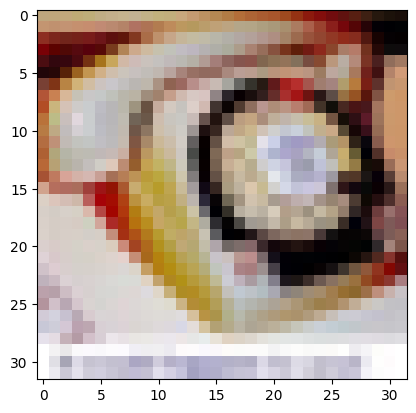

In [4]:
plt.imshow(data_train['data'][5])

## Data Augmentation


We implement the Cutout, Mixup and CutMix.

Reference:

Cutout [https://arxiv.org/abs/1708.04552](https://arxiv.org/abs/1708.04552)

Mixup [https://arxiv.org/abs/1710.09412v2](https://arxiv.org/abs/1710.09412v2)

CutMix [https://arxiv.org/abs/1905.04899](https://arxiv.org/abs/1905.04899)

In [5]:
from PIL import Image 
def augmentate(pics, labels = None, resize = (224, 224), augmentation = False, 
                cut = False, mix = False, rotate = 15):
    '''Simple data augmentator'''
    pics2 = []
    n = pics.shape[0]
    if resize is None:
        resize = pics[0].shape 
    
    if augmentation:
        angles = (np.random.random(n) - .5) * (rotate * 2.)
        flips = np.random.randint(0, 2, n)
        for i in range(n):
            pic = Image.fromarray(pics[i])
            if flips[i]: pic = pic.transpose(Image.FLIP_LEFT_RIGHT)
            pic = pic.resize(resize, Image.ANTIALIAS)
            pic = pic.rotate(angles[i])
            pic = np.array(pic)
            pics2.append(pic)
    
        if cut and not mix:
            # cutout
            cutx = np.random.randint(cut, resize[0], n)
            cuty = np.random.randint(cut, resize[1], n)
            for i in range(n):
                pics2[i][cutx[i]-cut : cutx[i], 
                         cuty[i]-cut : cuty[i], : ] = 0
            labels *= (1. - cut * cut / pics2[0].size)

        elif mix and not cut:
            # mixup
            couple = np.arange(n)
            np.random.shuffle(couple)
            propotion = np.random.random(n)

            # warning: do not modify in-place
            pics3 = [propotion[i] * pics2[couple[i]] + (1 - propotion[i]) * pics2[i] 
                        for i in range(n)]

            # pointer
            pics2 = pics3 

            labels = labels + (labels[couple] - labels) * propotion.reshape((n,1))

        elif cut and mix:
            # cutmix
            couple = np.arange(n)
            np.random.shuffle(couple)
            propotion = np.random.random(n)
            rw = (resize[0] * np.sqrt(propotion)).astype('uint8')
            rh = ((resize[1] / resize[0]) * rw).astype('uint8')

            rx = np.random.randint(65535, size = n) % (resize[0] - rw)
            ry = np.random.randint(65535, size = n) % (resize[1] - rh)

            # warning: do not modify in-place
            pics3 = np.array(pics2)
            for i in range(n):
                pics3[i][rx[i] : rx[i]+rw[i], ry[i] : ry[i]+rh[i]] = \
                    pics2[couple[i]][rx[i] : rx[i]+rw[i], ry[i] : ry[i]+rh[i]] 

            # pointer
            pics2 = pics3

            labels = labels + (labels[couple] - labels) * propotion.reshape((n,1))
            
    else: 
        # no augmentation but resizing
        for i in range(pics.shape[0]):
            pic = Image.fromarray(pics[i])
            pic = pic.resize(resize, Image.ANTIALIAS)
            pic = np.array(pic)
            pics2.append(pic)

    return np.array(pics2), labels

def resizer(pics, size):
    '''
    resize pictures to the given size
    '''
    if issubclass(type(pics[0]), np.ndarray):
        pics = [Image.fromarray(pic) for pic in pics]
    
    for i in range(len(pics)):
        pics[i] = pics[i].resize(size, Image.ANTIALIAS)
    
    return pics


def dataloader(data, labels, batch_size = 128, shuffle = True, verbose = True,
                resize = (224,224), augmentation = True, onehot = False,
                cut = False, mix = False, rotate = 15):
    order = np.arange(data.shape[0], dtype = 'int32')
    if shuffle: np.random.shuffle(order)
    labels = np.array(labels)
    __eye = np.eye(np.max(labels) + 1)
    gen = range(data.shape[0] // batch_size)
    if verbose: gen = tqdm(gen)
    for i in gen:
        x = data[order[i * batch_size: i * batch_size + batch_size]]
        l = labels[order[i * batch_size: i * batch_size + batch_size]]

        # extract the onehot encoding
        l = __eye[l]

        # augmentate the data
        x , l = augmentate(x, l, resize = resize, augmentation = augmentation, 
                            cut = cut, mix = mix, rotate = rotate)

        # transpose the dimensions to match (N,C,H,W)
        x = x.transpose((0,3,1,2))
        x = torch.tensor(x, dtype = torch.float32) / 255.

        # retrieve the non-onehot encoding if asked
        if not onehot:
            l = labels[order[i * batch_size: i * batch_size + batch_size]]
        yield x , l



def topk(y, labels, top):
    '''compute the number of hits in the top-k prediction'''
    topy = np.argpartition(y, -top, axis=-1)[:,-top:]
    topy -= labels.reshape((labels.shape[0], 1))
    return topy.size - np.count_nonzero(topy)


def test(net, data, batch_size = 100, resize = (224,224), tops = [1,5],
            verbose = False, label = 'fine', augmentation = False):
    accs = [0] * len(tops)
    tops.sort()
    for x, labels in dataloader(data['data'], data[f'{label}_labels'], resize = resize, 
                                  batch_size = batch_size, shuffle = False, verbose = verbose,
                                  augmentation = augmentation):
        y = net(x.to(_cuda_)).cpu().detach().numpy()
        labels = np.array(labels)
        for i in range(len(tops)):
            t = topk(y, labels, tops[i])
            accs[i] += topk(y, labels, tops[i])
    return np.array(accs) / data['data'].shape[0]

/home/liyuxin/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  


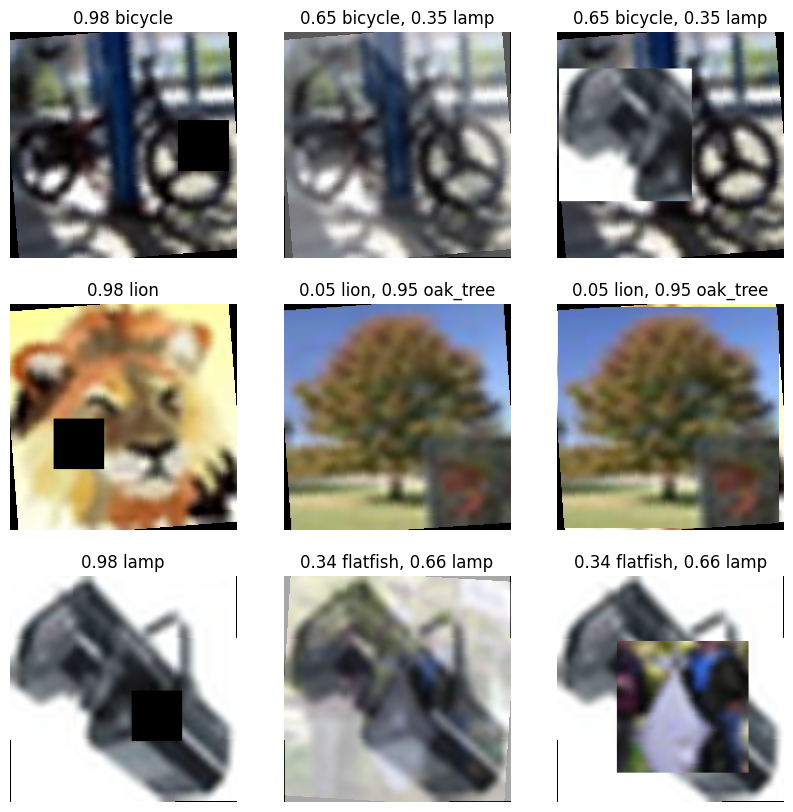

In [6]:
plt.figure(figsize=(10,10))
for i, method in enumerate(((50,False), (0, True), (50, True))):
    np.random.seed(314) # different seed matches different pictures
    for pics in dataloader(data_train['data'], data_train['fine_labels'], verbose = False,
                augmentation=True, onehot = True, cut = method[0], mix = method[1], rotate = 6):
        for j in range(3):
            plt.subplot(3,3,i + j*3 + 1)
            plt.imshow(pics[0][j].numpy().transpose((1,2,0)))
            plt.axis('off')
            plt.title(''.join([('%.2f %s, '%(p, data_meta['fine_label_names'][index]) if p > 0 else '')
                            for index, p in enumerate(pics[1][j])])[:-2] )
        break
plt.savefig('augmentation.png', bbox_inches='tight')

## Training

As a demo, we use the pretrained network and train around **??? minutes** on GPU.

In [7]:
_cuda_ = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(_cuda_)

cuda:0


## With data augmentation

In [8]:
#Define metric variables
#for baseline
baseline_data = torch.load('../models/datas/baseline_aug_data.pth')
loss_baseline, val_acc_baseline, test_acc_baseline = baseline_data['loss'],baseline_data['valid_acc'],baseline_data['test_acc']
#for cutout
cutout=torch.load('../models/datas/cutout_data.pth')
loss_cutout, val_acc_cutout, test_acc_cutout = cutout["loss"],cutout["valid_acc"],cutout["test_acc"]

#For cutmix
cutmix=torch.load('../models/datas/cutmix_data.pth')
loss_cutmix, val_acc_cutmix, test_acc_cutmix = cutmix["loss"],cutmix["valid_acc"],cutmix["test_acc"]
#for mixup

mixup=torch.load('../models/datas/mixup_data.pth')
loss_mixup, val_acc_mixup, test_acc_mixup = mixup["loss"],mixup["valid_acc"],mixup["test_acc"]

The best accuracy of Baseline is 71.36%
The best accuracy of Cutout is 72.17%
The best accuracy of Mixup is 75.41%
The best accuracy of Cutmix is 71.74%


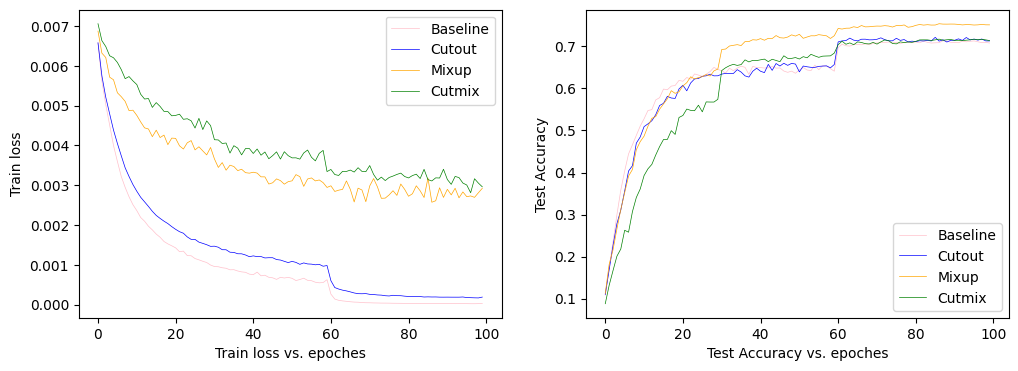

<Figure size 640x480 with 0 Axes>

In [9]:
print("The best accuracy of %s is %.2f"%('Baseline',100*max(test_acc_baseline))+'%')
print("The best accuracy of %s is %.2f"%('Cutout',100*max(test_acc_cutout))+'%')
print("The best accuracy of %s is %.2f"%('Mixup',100*max(test_acc_mixup))+'%')
print("The best accuracy of %s is %.2f"%('Cutmix',100*max(test_acc_cutmix))+'%')
x = range(100)
y1 = loss_baseline
y2 = loss_cutout
y3 = loss_mixup
y4 = loss_cutmix
w1 = test_acc_baseline
w2 = test_acc_cutout
w3 = test_acc_mixup
w4 = test_acc_cutmix
plt.subplot(1,2,1)
plt.plot(x,y1,color = 'pink',linewidth=0.5)
plt.plot(x,y2,color='blue',linewidth=0.5)
plt.plot(x,y3,color='orange',linewidth=0.5)
plt.plot(x,y4,color='green',linewidth=0.5)
plt.xlabel('Train loss vs. epoches')
plt.ylabel('Train loss')
plt.legend(['Baseline','Cutout','Mixup','Cutmix'])
plt.subplot(1,2,2)
plt.plot(x,w1,color='pink',linewidth=0.5)
plt.plot(x,w2,color='blue',linewidth=0.5)
plt.plot(x,w3,color='orange',linewidth=0.5)
plt.plot(x,w4,color='green',linewidth=0.5)
plt.xlabel('Test Accuracy vs. epoches')
plt.ylabel('Test Accuracy')
plt.legend(['Baseline','Cutout','Mixup','Cutmix'])
plt.gcf().set_size_inches(12, 4)
# plt.savefig('./fig/cmp_with_aug.png')
plt.show()
# plt.savefig('./output/img_test.eps', dpi=300)
plt.savefig('../models/output/img_test.png')